In [1]:
##############3
#Asta pare cel mai bun. Trebuie multa antrenare si probabil pe mutiple poze. 
#Luati facial_recognition si aplicati pe imamginile astea in schimb (mai puteti obtine mai multe imagini pt acceasi persoana
#folosind transformarrile de aici in codul MTCNN). Mai jucati-va si cu arhitectura. Asta e mai buna decat aia de la Google
#dupa oleaca de testare.
#Sau angajati 1-2 din echipa de la facial_recognition care costa mult mai putin decat 100 milioane de euro.
#Succes.
##############
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv 
import glob 
import dlib
import pandas as pd
import numpy as np


#Imports inside facenet scripts that need to be loaded here on google colab.
import requests
from requests.adapters import HTTPAdapter
import torch
import hashlib
import shutil
import tempfile
from urllib.request import urlopen, Request

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

#####################
#Global valriables
####################
#The following variable determines how many pictures are fed at once into the NN (this is made for speed).
batches=32   
#The following path points to the folder that contains the images with faces only.
data_dir=r"C:\Users\mihnea.andrei\Python scripts\resnet_andrei\images_faces"

def imshow(inp,title=None):
  ############
  #Imshow for tensor
  #############
    inp=inp.numpy().transpose([1,2,0])
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    inp=std*inp+mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.0001)

#The following function times the NN.
def timming(since):
    time_elapsed=time.time()-since
    minutes=time_elapsed // 60
    seconds=time_elapsed%60
    return "%d m:%d s"%(minutes,seconds)

Running on device: cpu


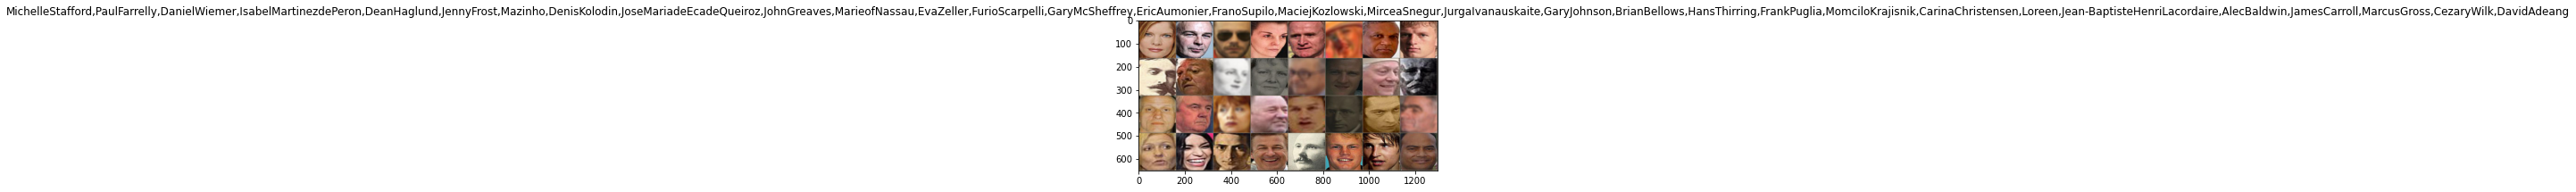

In [2]:
#If you use the MTCNN code that does the random transformations also, you do not need all those transformations again 
#(maybe) except the horizonta flip - the angle from which the picture is taken.
data_transforms={
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  
        #transforms.ColorJitter(brightness=0.5,contrast=0.5),
        #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(3, 7)),
        #transforms.RandomAdjustSharpness(sharpness_factor=15),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'eval': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
}
phases=list(data_transforms.keys())
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in list(data_transforms.keys())}
dataloaders={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=batches,shuffle=True) for x in list(data_transforms.keys())}
data_sizes={x:len(image_datasets[x]) for x in list(data_transforms.keys())}
class_names=image_datasets['train'].classes 

inputs, classes = next(iter(dataloaders['train']))
out=utils.make_grid(inputs)
imshow(out,title=",".join([class_names[i] for i in classes.tolist()])) 

In [3]:
#the following is a class for a neuron (the smallest part of this "brain").
class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(
            in_planes, out_planes,
            kernel_size=kernel_size, stride=stride,
            padding=padding, bias=False
        ) # verify bias false
        self.bn = nn.BatchNorm2d(
            out_planes,
            eps=0.001, # value found in tensorflow
            momentum=0.1, # default pytorch value
            affine=True
        )
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x            #in_planes x out_planes


class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(256, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(256, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(96, 256, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)                # 256x32
        x1 = self.branch1(x)                # 256x32 * 32x32=256x32
        x2 = self.branch2(x)                # 256x32 * 32x32 * 32x32=256x32
        # concatenate dimenion 1 (1 for python is 2 for us=columns): 256x(32+32+32)=256x96
        out = torch.cat((x0, x1, x2), 1)    
        out = self.conv2d(out)              # 256x96 * 96x256=256x256
        out = out * self.scale + x
        out = self.relu(out)
        return out                          # 256x256 is the output

#################################
#Block 4
#Add nother block multi-layer of output 3840x3840
#################################
class Block4(nn.Module):
    def __init__(self,scale=1.0,noReLU=False):
        super().__init__()
        self.scale=scale
        self.noReLU=noReLU
        
        self.branch0=BasicConv2d(3840,256,kernel_size=1,stride=1)
        
        self.branch1=nn.Sequential(
            BasicConv2d(3840,256,kernel_size=1,stride=1),
            BasicConv2d(256,256,kernel_size=3,stride=1,padding=1)
        )
        
        self.branch2=nn.Sequential(
            BasicConv2d(3840,256,kernel_size=1,stride=1),
            BasicConv2d(256,256,kernel_size=3,stride=1,padding=1),
            BasicConv2d(256,256,kernel_size=3,stride=1,padding=1)
        )
        
        self.conv2d=nn.Conv2d(768,3840,kernel_size=1,stride=1)
        self.relu=nn.ReLU(inplace=False)
    
    def forward(self,x):
        x0=self.branch0(x)            #3840x256
        x1=self.branch1(x)            #3840x256
        x2=self.branch2(x)            #3840x256
        out=torch.cat((x0,x1,x2),1)   #3840x(256+256+256)=3840x768
        out=self.conv2d(out)          #768x3840
        out=out*self.scale+x
        out=self.relu(out)
        return out                    #3840x3840

    
class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super().__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(896, 128, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 128, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(128, 128, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(256, 896, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)              # 896x128
        x1 = self.branch1(x)              # 896x128 * 128x128 * 128x128 = 896x128
        #concatenate columns (1 for python is 2 for us-columns-2nd dimension): 896 x (128+128)=896x256
        out = torch.cat((x0, x1), 1)      
        out = self.conv2d(out)            # 896x256*256x896=896x896
        out = out * self.scale + x
        out = self.relu(out)
        return out                        # 896x896 is the output


class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super().__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(1792, 192, kernel_size=1, stride=1)           

        self.branch1 = nn.Sequential(
            BasicConv2d(1792, 192, kernel_size=1, stride=1),                 
            BasicConv2d(192, 192, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(192, 192, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(384, 1792, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)                # 1792x192
        x1 = self.branch1(x)                # 1792x192*192x192*192x192=1792x192
        out = torch.cat((x0, x1), 1)        # 1792x(192+192)=1792x384
        out = self.conv2d(out)              # 1792x384*384x1792=1792x1792
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out                          # 1792x1792 is the output

class Mixed_6a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = BasicConv2d(256, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(256, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 192, kernel_size=3, stride=1, padding=1),
            BasicConv2d(192, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)                # 256x384
        x1 = self.branch1(x)                # 256x192*192x192*192x256=256x256
        x2 = self.branch2(x)                # 256x256
        out = torch.cat((x0, x1, x2), 1)    # 256x(384+256+256)=256x896
        return out


class Mixed_7a(nn.Module):

    def __init__(self):
        super().__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(896, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 256, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)                   # 896x256*256x384= 896x384
        x1 = self.branch1(x)                   # 896x256*256x256= 896x256
        x2 = self.branch2(x)                   # 896x256*256x256*256x256=896x256
        x3 = self.branch3(x)                   # 896x896
        out = torch.cat((x0, x1, x2, x3), 1)   # 896x(384+256+256+896)=896x1792
        return out

########################
#Add another mixed multi-layer with output 1792x3584.
########################
class Mixed_8a(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.branch0=nn.Sequential(
            BasicConv2d(1792,384,kernel_size=1,stride=1),
            BasicConv2d(384,512,kernel_size=3,stride=2)
        )
        
        self.branch1=nn.Sequential(
            BasicConv2d(1792,512,kernel_size=1,stride=1),
            BasicConv2d(512,512,kernel_size=3,stride=2)
        )
        
        self.branch2=nn.Sequential(
            BasicConv2d(1792,512,kernel_size=1,stride=1),
            BasicConv2d(512,512,kernel_size=3,stride=1,padding=1),
            BasicConv2d(512,512,kernel_size=3,stride=2)
        )
        
        self.branch3=nn.Sequential(
            BasicConv2d(1792,512,kernel_size=1,stride=1),
            BasicConv2d(512,512,kernel_size=3,stride=1,padding=1),
            BasicConv2d(512,512,kernel_size=3,stride=1,padding=1),
            BasicConv2d(512,512,kernel_size=3,stride=2)
        )
        
        self.branch4=nn.MaxPool2d(3,stride=2)
        
    def forward(self,x):
        x0=self.branch0(x)                    # 1792x512
        x1=self.branch1(x)                    # 1792x512
        x2=self.branch2(x)                    # 1792x512
        x3=self.branch3(x)                    # 1792x512
        x4=self.branch4(x)                    # 1792x1792
        out=torch.cat((x0,x1,x2,x3,x4),1)     # 1792x3840
        return out 
        

class InceptionResnetV1(nn.Module):
    """Inception Resnet V1 model with optional loading of pretrained weights.
    Model parameters can be loaded based on pretraining on the VGGFace2 or CASIA-Webface
    datasets. Pretrained state_dicts are automatically downloaded on model instantiation if
    requested and cached in the torch cache. Subsequent instantiations use the cache rather than
    redownloading.
    Keyword Arguments:
        pretrained {str} -- Optional pretraining dataset. Either 'vggface2' or 'casia-webface'.
            (default: {None})
        classify {bool} -- Whether the model should output classification probabilities or feature
            embeddings. (default: {False})
        num_classes {int} -- Number of output classes. If 'pretrained' is set and num_classes not
            equal to that used for the pretrained model, the final linear layer will be randomly
            initialized. (default: {None})
        dropout_prob {float} -- Dropout probability. (default: {0.6})
    """
    def __init__(self, num_classes=None, dropout_prob=0.6):
        super().__init__()

        # Set simple attributes
        self.num_classes = num_classes

        # Define layers
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.conv2d_4b = BasicConv2d(192, 256, kernel_size=3, stride=2)
        self.repeat_1 = nn.Sequential(
            Block35(scale=0.17),                       # 256x256
            Block35(scale=0.17),                       # 256x256
            Block35(scale=0.17),                       # 256x256 
            Block35(scale=0.17),                       # 256x256
            Block35(scale=0.17)                        # 256x256
        )                                              # 256x256
        self.mixed_6a = Mixed_6a()                     # 256x896
        self.repeat_2 = nn.Sequential(
            Block17(scale=0.10),                       # 896x896
            Block17(scale=0.10),                       # 896x896
            Block17(scale=0.10),                       # 896x896
            Block17(scale=0.10),                       # 896x896
            Block17(scale=0.10),                       # 896x896
            Block17(scale=0.10),                       # 896x896
            Block17(scale=0.10),                       # 896x896
            Block17(scale=0.10),                       # 896x896
            Block17(scale=0.10),                       # 896x896
            Block17(scale=0.10)                        # 896x896
        )                                              # 896x896
        self.mixed_7a = Mixed_7a()                     # 896x1792 
        self.repeat_3 = nn.Sequential(
            Block8(scale=0.20),                        # 1792x1792
            Block8(scale=0.20),                        # 1792x1792
            Block8(scale=0.20),                        # 1792x1792
            Block8(scale=0.20),                        # 1792x1792
            Block8(scale=0.20)                         # 1792x1792
        )                                              # 1792x1792
        #Make a Mixed_8a() of 1792x3584 for example
        self.mixed_8a=Mixed_8a()                       # 1792x3840
        #Make a Block of 3840x3840
        self.repeat_4=nn.Sequential(
            Block4(scale=0.2),                         # 3840x3840
            Block4(scale=0.2),                         # 3840x3840
            Block4(scale=0.2),                         # 3840x3840
            Block4(scale=0.2),                         # 3840x3840
            Block4(scale=0.2)                          # 3840x3840
        )
        self.block4=Block4(noReLU=True)                # 3840x3840
        self.avgpool_1a = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_prob)
        self.last_linear = nn.Linear(3840, 1024, bias=False)
        self.last_bn = nn.BatchNorm1d(1024, eps=0.001, momentum=0.1, affine=True)
        self.logits = nn.Linear(1024, self.num_classes)
        self.logsoftmax = nn.LogSoftmax(dim=1)

        
    def forward(self, x):
        """Calculate embeddings or logits given a batch of input image tensors.
        Arguments:
            x {torch.tensor} -- Batch of image tensors representing faces.
        Returns:
            torch.tensor -- Batch of embedding vectors or multinomial logits.
        """
        x = self.conv2d_1a(x)                               # 3x32
        x = self.conv2d_2a(x)                               # 3x32*32x32=3x32
        x = self.conv2d_2b(x)                               # 3x32*32x64=3x64
        x = self.maxpool_3a(x)                              
        x = self.conv2d_3b(x)                               # 3x64*64x80=3x80
        x = self.conv2d_4a(x)                               # 3x80*80x192=3x192
        x = self.conv2d_4b(x)                               # 3x192*192x256=3x256
        x = self.repeat_1(x)                                # 3x256*256x256=3x256
        x = self.mixed_6a(x)                                # 3x256*256x896=3x896
        x = self.repeat_2(x)                                # 3x896*896x896=3x896
        x = self.mixed_7a(x)                                # 3x896*896x1792=3x1792
        x = self.repeat_3(x)                                # 3x1792*1792x1792=3x1792
        x = self.mixed_8a(x)                                # 3x1792*1792x3840=3x3840
        x = self.block4(x)                                  # 3x3840*3840x3840=3x3840
        x = self.avgpool_1a(x)
        x = self.dropout(x)
        x = self.last_linear(x.view(x.shape[0], -1))        # 3x3840*3840x1024=3x1024
        x = self.last_bn(x)                                 # 3x1024*1024xnum_classes=3xnum_classes
        x = self.logits(x)
        x = self.logsoftmax(x)
        
        return x

In [4]:
model_fit=InceptionResnetV1(num_classes=data_sizes["train"]).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model_fit.parameters(),lr=10**(-2),momentum=0.9)
#optimizer=torch.optim.Adam(model_fit.parameters(),lr=10**(-2), betas=(0.9, 0.999), eps=1e-08)
exp_lr_decay=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [ ]:
num_epochs=25
best_model_weights=copy.deepcopy(model_fit.state_dict())
best_acc=0
since=time.time()
printing_iter=10**(1)

for epoch in range(num_epochs):
    print("-"*100)
    print("Training for epoch %d/%d started"%(epoch+1,num_epochs))
    print("-"*100)
    
    train_losses=[]
    train_accs=[]
    counter=0

    for x, label in dataloaders["train"]:
        x=x.to(device)
        label=label.to(device)
        
        optimizer.zero_grad()
        
        output=model_fit(x)
        loss=criterion(output,label)
        
        output=torch.exp(output)
        _, pred=output.topk(1,dim=1)
        
        loss.backward()
        optimizer.step()
        exp_lr_decay.step()
        
        last_loss=loss.item()
        train_losses.append(last_loss)    
        last_acc=torch.sum(pred==label.data).double()
        train_accs.append(last_acc)

        counter+=1
        if counter%printing_iter==0:
            print("Train completion:%.2f%%, time:%s, avg loss: %.2f, avg acc:%.2f%%, last loss: %.2f"
                  %(100*counter*batches/data_sizes["train"],timming(since),np.mean(train_losses),
                    100*np.mean(train_accs),last_loss))
    
    training_avg_loss=np.mean(train_losses)
    training_avg_accuracy=100*np.mean(train_accs)
    print("-"*100)
    print("Eval for epoch %d/%d started"%(epoch+1,num_epochs))
    print("-"*100)
    
    since=time.time()
    counter=0
    eval_losses=[]
    eval_accs=[]
    
    with torch.no_grad():
        for x, label in dataloaders["eval"]:
            
            output=model_fit(x)
            loss=criterion(output,label)
            
            output=torch.exp(output)
            _, pred=output.topk(1,dim=1)
            
            
            last_loss=loss.item()
            eval_losses.append(last_loss)
            last_acc=torch.sum(pred==label.data).double()
            eval_accs.append(last_acc)
            
            counter+=1
            if counter%printing_iter==0:
                print("Eval completion:%.2f%%, time:%s, avg loss: %.2f, avg acc:%.2f%%, last loss: %.2f"
                      %(100*counter*batches/data_sizes["eval"],timming(since),np.mean(eval_losses),
                        100*np.mean(eval_accs),last_loss))
            
    eval_avg_loss=np.mean(eval_losses)
    eval_avg_acc=100*np.mean(eval_accs)
    
    print("-"*100)
    print("Completed epoch %d/%d in %s, avg train loss: %.2f, avg train acc: %.2f%%, avg eval loss: %.2f, avg eval acc: %.2f"%
          (epoch+1,num_epochs,timming(since),training_avg_loss,training_avg_accuracy,eval_avg_loss,eval_avg_acc))
    print("-"*100)
    
    
        

----------------------------------------------------------------------------------------------------
Training for epoch 1/25 started
----------------------------------------------------------------------------------------------------
Train completion:0.05%, time:1 m:3 s, avg loss: 13.57, avg acc:0.00%, last loss: 13.60
Train completion:0.09%, time:2 m:5 s, avg loss: 13.57, avg acc:0.00%, last loss: 13.52
Train completion:0.14%, time:3 m:7 s, avg loss: 13.57, avg acc:0.00%, last loss: 13.58
Train completion:0.19%, time:4 m:11 s, avg loss: 13.58, avg acc:0.00%, last loss: 13.64
Train completion:0.24%, time:5 m:16 s, avg loss: 13.58, avg acc:0.00%, last loss: 13.49
Train completion:0.28%, time:6 m:22 s, avg loss: 13.59, avg acc:0.00%, last loss: 13.68
Train completion:0.33%, time:7 m:30 s, avg loss: 13.60, avg acc:0.00%, last loss: 13.69
Train completion:0.38%, time:8 m:36 s, avg loss: 13.60, avg acc:1.25%, last loss: 13.59
Train completion:0.42%, time:9 m:43 s, avg loss: 13.59, avg acc:1